In [8]:
#Samson Koelle
#Meila group
#021419


#rootdirectory = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients'
#f = open(rootdirectory + '/code/source/packagecontrol.py')
#source = f.read()
#exec(source)
#f = open(rootdirectory + '/code/source/sourcecontrol.py')
#source = f.read()
#exec(source)
#f = open(rootdirectory + '/code/source/RigidEthanol.py')
#source = f.read()
#exec(source)
import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
#print(os.getcwd())
from codes.experimentclasses.RigidEthanolPCA import RigidEthanolPCA
from codes.otherfunctions.multirun import get_coeffs_reps_tangent
from codes.otherfunctions.multirun import get_grads_reps_pca2_tangent
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch_tangent
from codes.otherfunctions.get_dictionaries import get_atoms_4
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.get_grads_tangent import get_grads_tangent
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
import matplotlib.pyplot as plt
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.geometer.RiemannianManifold import RiemannianManifold
from collections import Counter

#set parameters
n = 10000 #number of data points to simulate
nsel = 50 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,0,7), np.logspace(0,2,5),np.logspace(2,3,2)]), dtype = np.float16)
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-2,1,15)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
n_components = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
#diffusion_time =.05 #(yuchia suggestion)
diffusion_time =.25 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)

m = 3
new_MN = True
new_grad = True
savename = 'rigidethanol_032520'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_032520'
nreps = 5
atoms4,p = get_atoms_4(9,ii,jj)
folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

if new_MN == True:
    experiment = RigidEthanolPCA(dim, cor,var,ii,jj, cores, False, atoms4)
    #projector  = np.load(workingdirectory + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
    #experiment.M = experiment.load_data()  # if noise == False then noise parameters are overriden
	#experiment.Mpca = RiemannianManifold(np.load(workingdirectory + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=False)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
             'wb') as output:
         pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)

lambda_max = 1
max_search = 30

experiment.p = p# + experiment.d
experiment.atoms4 = atoms4
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
experiment.folder = folder
experiment.m = dim
replicates = {}
selected_points_save = np.zeros((nreps,nsel))
for i in range(nreps):
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads_tangent(experiment, experiment.Mpca, experiment.M, selected_points, False)
    replicates[i].xtrain, replicates[i].groups = experiment.construct_X(replicates[i].dg_M)
    replicates[i].ytrain = experiment.construct_Y(replicates[i].df_M)#,list(range(nsel)))
    replicates[i].coeff_dict = {}
    replicates[i].coeff_dict[0] = experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, np.asarray([0]), nsel, experiment.dim, itermax, tol)
    replicates[i].combined_norms = {}
    replicates[i].combined_norms[0] = np.linalg.norm(np.linalg.norm(replicates[i].coeff_dict[0][:, :, :, :], axis=2), axis=1)[0,:]
    replicates[i].higher_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_support_recovery_lambda(experiment, replicates[i],  lambda_max, max_search,dim)
    replicates[i].lower_lambda,replicates[i].coeff_dict,replicates[i].combined_norms = get_lower_interesting_lambda(experiment, replicates[i],  lambda_max, max_search)
    #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)

for i in range(nreps):
    replicates[i].coeffs, replicates[i].lambdas_plot = get_coeffs_and_lambdas(replicates[i].coeff_dict, replicates[i].lower_lambda, replicates[i].higher_lambda)

#nreps = 5



0 1
1 0.5
2 0.75
3 0.375
4 0.5625
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
we did it
0 1
1 0.5
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
we did it
0 1
1 0.5
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.0517578125e-05
16 1.52587890625e-05
17 7.62939453125e-06
we did it
0 1
1 0.5
we did it
0 1
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078125
8 0.00390625
9 0.001953125
10 0.0009765625
11 0.00048828125
12 0.000244140625
13 0.0001220703125
14 6.103515625e-05
15 3.051757

In [12]:

def get_support(coeffs, dim):
    selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

    sls = np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0]
    if len(sls) > 0:
        selection_lambda = np.min(sls)
        selected_functions_at_selection_lambda = selected_functions[1][
            np.where(selected_functions[0] == selection_lambda)[0]]

        return (selected_functions_at_selection_lambda)
    else:
        return(np.nan)


In [13]:
supports = {}
for i in range(nreps):
    #print(i)
    supports[i] = get_support(replicates[i].coeffs, dim)

In [14]:
supports

{0: array([0, 6]),
 1: array([3, 9]),
 2: array([3, 9]),
 3: array([0, 9]),
 4: array([3, 9])}

In [19]:
    coeffs = replicates[0].coeffs
    selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

    sls = np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0]
    if len(sls) > 0:
        selection_lambda = np.min(sls)
        selected_functions_at_selection_lambda = selected_functions[1][
            np.where(selected_functions[0] == selection_lambda)[0]]


In [20]:
r = replicates[0]
sls


array([17])

In [292]:
selpt = np.array([ 0,  1,  3,  5,  7,  9, 11, 13, 15, 16, 18, 20, 22, 24, 26, 28, 30,
       31, 33, 35, 37, 39, 41, 43, 45])
selpt = selpt[:10]
#selpt = selpt[[0,2,4,6,8]]
#selpt = selpt[[1,3,5,7,9]]
xtrain,groups = experiment.construct_X(replicates[0].dg_M[selpt])
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = len(selpt)))
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.45*r.lambdas_plot[17]]), len(selpt), 2, itermax, tol)

In [293]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([  0.        ,   0.        ,   0.        ,   8.88433016,
         0.        ,   0.        , 260.66335141,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [309]:
selpt = np.array([ 0,  1,  3,  5,  7,  9, 11, 13, 15, 16, 18, 20, 22, 24, 26, 28, 30,
       31, 33, 35, 37, 39, 41, 43, 45])
selpt = selpt[:10]
xtrain,groups = experiment.construct_X(replicates[0].dg_M[selpt][:,[3,6,9],:])
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = len(selpt)))
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.45*r.lambdas_plot[17]]), len(selpt), 2, itermax, tol)

In [310]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([  8.89097954, 260.57872876,   0.        ])

In [318]:
np.save('/Users/samsonkoelle/Desktop/abadxtrain',xtrain)

In [322]:
cs = experiment.get_betas_sam(xtrain, ytrain, groups, np.asarray([.45*r.lambdas_plot[sls[0]]]), 10, 2, itermax, .1*tol, 1)

(60,)
converged 0.253125


In [323]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([ 10.08346247, 246.59361781,   0.        ])

In [324]:
    from codes.flasso.GLMaccelerated import GLM
    def fhatlambda(self,lamb,betanew,betaold):
        xs = self.xs
        ys = self.ys
        #print(ys.shape,'fhatlam')
        #print(self._L2loss(betaold,xs,ys),self._L2loss(betanew,xs,ys),'old','new') 
        output = self._L2loss(betaold,xs,ys) + np.dot(self._grad_L2loss(betaold,xs,ys).transpose(),(betanew-betaold)) + (1/(2*lamb)) * np.linalg.norm(betanew-betaold)**2
        return(output)    

    def _prox(self,beta, thresh):
        """Proximal operator."""
        
        #print(thresh, beta)
        #print('beginprox', beta[0:2],thresh)
        group_ids = np.unique(self.group)
        result = np.zeros(beta.shape)
        result = np.asarray(result, dtype = float)
        #print('gids',group_ids)
        for i in range(len(group_ids)):
            gid = i 
            #print(self.group)
            idxs_to_update = np.where(self.group == gid)[0]
            #print('idx',idxs_to_update)
            #print('norm', np.linalg.norm(beta[idxs_to_update]))
            if np.linalg.norm(beta[idxs_to_update]) > 0.:
                #print('in here', len(idxs_to_update))
                potentialoutput = beta[idxs_to_update] - (thresh / np.linalg.norm(beta[idxs_to_update])) * beta[idxs_to_update]
                posind = np.where(beta[idxs_to_update] > 0.)[0]
                negind = np.where(beta[idxs_to_update] < 0.)[0]
                po = beta[idxs_to_update].copy()
                #print('potention', potentialoutput[0:2])
                po[posind] = np.asarray(np.clip(potentialoutput[posind],a_min = 0., a_max = 1e15), dtype = float)
                po[negind] = np.asarray(np.clip(potentialoutput[negind],a_min = -1e15, a_max = 0.), dtype = float)
                result[idxs_to_update] = po
        #print('end', result[0:2])
        return result

    #_btalgorithm(yk,lamb,.5,1000, rl)
    def _btalgorithm(self,bet,lam,b,maxx,rl):
        
        #print('lam',lam)
        X = self.xs
        y = self.ys
        grad_beta = self._grad_L2loss(beta = bet, X = X, y = y)
        for i in range(maxx):
            betn = bet - lam * grad_beta
            z = self._prox(betn, lam * rl)
            fz = self._L2loss(z,X,y)
            #print(fz,'fz')
            fhatz = self.fhatlambda(lam,z, bet)
            if fz <= fhatz:
            #print(fhatz - fz)
            #if 0 <= 1:
                break
            lam = b*lam
        return(z,lam)

In [329]:
        max_iter = itermax
        learning_rate = 1.
        n = 50
        q = 2
        lambdas = np.asarray([.45*r.lambdas_plot[sls[0]]])
        #def get_betas_sam(self, xtrain, ytrain, groups, lambdas, n, q, max_iter, tol, learning_rate):

        p = len(np.unique(groups))
        models = GLM(xs=xtrain, ys=ytrain,
                     tol=tol,
                     group=groups,
                     learning_rate=learning_rate,
                     max_iter=max_iter,
                     # reg_lambda=np.logspace(np.log(100), np.log(0.01), 5, base=np.exp(1)))
                     reg_lambda=lambdas,
                     parameter=.5)
        models.fit()
        nlam = len(lambdas)
        #organizedbetas = np.zeros((nlam, q, n, p))
        #for l in range(nlam):
        #    organizedbetas[l, :, :, :] = np.reshape(models.fit_[l]['beta'], (q, n, p))
        # return(models, organizedbetas)
        #return (organizedbetas)

(60,)
converged 0.253125


In [330]:
        #def _grad_L2loss(beta, X, y):
        X = xtrain
        y = ytrain
        beta = models.fit_[0]['beta']
        #print(beta.shape,X.shape,y.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        n_samples = np.float(X.shape[0])
        z = np.dot(X, beta)
        #grad_beta = 1. / n_samples * np.transpose(np.dot(np.transpose(z - y), X))
        grad_beta = np.transpose(np.dot(np.transpose(z - y), X))
        #print('gb',grad_beta.shape)
        #return grad_beta

In [346]:
np.dot(np.transpose(z - y)[0,[0,1,30,31]],  X[[0,1,20,21]][:,[0,1,2,30,31,32]])

array([ 0.07787797, -0.08164005, -0.00492303,  0.0026874 , -0.00180239,
       -0.074917  ])

In [350]:
beta[[0,1,2,30,31,32],:]

array([[-0.61441095],
       [ 1.53289937],
       [ 0.        ],
       [-0.03431378],
       [ 0.06243387],
       [ 0.        ]])

In [353]:
z[:5,0]

array([ 0.22268263,  0.01000106,  0.22977193, -0.0274415 ,  0.00081364])

In [331]:
np.linalg.norm(np.linalg.norm(np.reshape(beta, (q, 10, p)), axis = 1)**2, axis = 0)**2

array([  8.43478758, 267.03090621,   0.        ])

When the distance to the target vector is  would be improved 
Gain in l2 loss is sublinear when distance is less than $\frac{\lambda}{2}$ to target, so we won't get closer than this. 

\begin{eqnarray*}
l = \arg \min  \| Y - X \beta \|_2^2 + \sum_{j = 1}^p \|beta_j\|_2 \\
\nabla l (\beta = [4.2,...]) \\
= \arg \min \sum \| I - X \beta \|_2^2 + \sum_{j = 1}^p \|  [ \beta_1, \dotsc \beta_{dd} ,...] \|_2
\end{eqnarray*}

If we add weight to the already nonzero group, then we have loss increased by 
\begin{eqnarray*}
\end{eqnarray*}
since l2 norm is less than l1 norm, new coefficients will be added in the same group. We will increase coefficients in the same group versus add a new group when the gradient is greater in the group. For every point, the l2 gradient is the correlation of the features with the loss $X^T (I_d - X \beta) \in \mathbb R^{d \times p}$, which, when $\beta$ is small due to high $\lambda$, will scale with $X^T$.

Why is a new coefficient added when we can decrease loss substantially with the first coefficient?

In [417]:
xtrain,groups = experiment.construct_X(replicates[0].dg_M[selpt][:,[3,6,9],:])
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = len(selpt)))
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.45*r.lambdas_plot[17]]), len(selpt), 2, itermax, tol)

In [441]:
Xtest = np.asarray([[[1,0],[1,0.1],[0,.5]]])#.5]]])
xtrain,groups = experiment.construct_X(Xtest)
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = 1))

In [442]:
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([r.lambdas_plot[17]]), 1, 2, 100*itermax, .001*tol)

In [443]:
cs

array([[[[ 0.11955952,  0.31884468,  0.        ]],

        [[-0.00678796,  0.03867242,  0.        ]]]])

In [431]:
    #def get_betas_sam(self, xtrain, ytrain, groups, lambdas, n, q, max_iter, tol, learning_rate):
    lambdas = np.asarray([r.lambdas_plot[17]])
    n= 1
    q =2
    max_iter = itermax
    learning_rate = 1.
    p = len(np.unique(groups))
    models = GLM(xs=xtrain, ys=ytrain,
                 tol=tol,
                 group=groups,
                 learning_rate=learning_rate,
                 max_iter=max_iter,
                 # reg_lambda=np.logspace(np.log(100), np.log(0.01), 5, base=np.exp(1)))
                 reg_lambda=lambdas,
                 parameter=.5)
    models.fit()
    nlam = len(lambdas)
    organizedbetas = np.zeros((nlam, q, n, p))
    for l in range(nlam):
        organizedbetas[l, :, :, :] = np.reshape(models.fit_[l]['beta'], (q, n, p))
    # return(models, organizedbetas)
    #return (organizedbetas)


(6,)
converged 0.5625


In [432]:
models.fit_[l]['beta']

array([[ 0.11975375],
       [ 0.31865201],
       [ 0.        ],
       [-0.00679489],
       [ 0.0386602 ],
       [ 0.        ]])

In [433]:
xtrain

array([[1. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0.5]])

In [463]:
np.dot(xtrain, models.fit_[l]['beta'])

array([[0.43840576],
       [0.0318652 ],
       [0.03186531],
       [0.00386602]])

In [450]:
err= np.asarray([[1,0,0,1]]).transpose() - np.dot(xtrain, models.fit_[l]['beta'])

In [465]:
print(err, np.linalg.norm(err**2))

[[ 0.56159424]
 [-0.0318652 ]
 [-0.03186531]
 [ 0.99613398]] 1.0411998254222614


In [468]:
#groups
#group = self.group
group_ids = np.unique(groups)
L1penalty = 0.0
for group_id in group_ids:
    L1penalty += np.linalg.norm(models.fit_[l]['beta'][groups == group_id], 2)

In [470]:
L1penalty

0.4409350188813433

In [451]:
np.dot(xtrain.transpose(), err)


array([[ 0.56159424],
       [ 0.55840772],
       [-0.0159326 ],
       [-0.03186531],
       [ 0.06774809],
       [ 0.49806699]])

In [452]:
models.fit_[l]['beta']

array([[ 0.11975375],
       [ 0.31865201],
       [ 0.        ],
       [-0.00679489],
       [ 0.0386602 ],
       [ 0.        ]])

In [471]:
bettt = models.fit_[l]['beta'].copy()

In [474]:
bettt[0,0] = bettt[0,0] + bettt[1,0]
bettt[3,0] = bettt[3,0] + bettt[4,0]
bettt[1,0] = 0.
bettt[4,0] = 0.

In [475]:
err= np.asarray([[1,0,0,1]]).transpose() - np.dot(xtrain, bettt)

In [477]:
print(err, np.linalg.norm(err**2))

[[ 0.56159424]
 [ 0.        ]
 [-0.03186531]
 [ 1.        ]] 1.0485564738990558


In [478]:
#groups
#group = self.group
group_ids = np.unique(groups)
L1penalty = 0.0
for group_id in group_ids:
    L1penalty += np.linalg.norm(bettt[groups == group_id], 2)

In [479]:
L1penalty

0.43956229119586826

In [458]:
np.linalg.norm(replicates[0].dg_M, axis = 2)[0]

array([0.10689735, 0.09744196, 0.09748166, 0.10039989, 0.09195794,
       0.09195385, 0.10517544, 0.09638328, 0.09649321, 0.09160783,
       0.0918076 , 0.09084874])

In [460]:
np.linalg.norm(replicates[0].dg_M, axis = 2)[2]

array([0.11165893, 0.10160898, 0.10156451, 0.07206007, 0.06551289,
       0.06544481, 0.10983474, 0.10015332, 0.10019698, 0.05076601,
       0.05060818, 0.05074339])

In [462]:
np.linalg.norm(replicates[0].dgw_norm, axis = 2)[2]

array([0.14131968, 0.14022741, 0.13973233, 0.13370804, 0.135019  ,
       0.1351492 , 0.14222888, 0.14236823, 0.14219136, 0.05114664,
       0.05214419, 0.05164038])

In [425]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([0.00020433, 0.01033738, 0.        ])

In [426]:
xtrain

array([[1. , 1. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0.5]])

In [409]:
np.linalg.norm([0.5,0.5])

0.7071067811865476

In [332]:
#lambdas
bet = beta
rl = .45*r.lambdas_plot[sls[0]]
lam  = learning_rate
b = .5
maxx = 1000

In [333]:
        models = GLM(xs=xtrain, ys=ytrain,
                     tol=tol,
                     group=groups,
                     learning_rate=learning_rate,
                     max_iter=max_iter,
                     # reg_lambda=np.logspace(np.log(100), np.log(0.01), 5, base=np.exp(1)))
                     reg_lambda=lambdas,
                     parameter=.5)

In [141]:

betanw , lamnew = models._btalgorithm(bet,lam,b,maxx,rl)

In [158]:
print(bet[:12,0])
print(betanw[:12,0])
print(models._loss(betanw, rl, X, y))
print(models._loss(beta, rl, X, y))

[-1.50664508  0.          0.          0.          0.          0.
  0.72580604  0.          0.          0.          0.          0.        ]
[-1.50664508  0.          0.          0.          0.          0.
  0.72580604  0.          0.          0.          0.          0.        ]
9126.702529783111
9126.702529783111


In [146]:
        X = xtrain
        y = ytrain
        self = models
        grad_beta = self._grad_L2loss(beta = bet, X = X, y = y)
        for i in range(maxx):
            #i = 0
            betn = bet - lam * grad_beta
            z = self._prox(betn, lam * rl)
            fz = self._L2loss(z,X,y)
            #print(fz,'fz')
            fhatz = self.fhatlambda(lam,z, bet)
            if fz <= fhatz:
            #print(fhatz - fz)
            #if 0 <= 1:
                print('ye')
                break
            lam = b*lam

ye


In [157]:
print(models._loss(betanw, rl, X, y)-(models._loss(betn, rl, X, y)))
print(models._loss(betanw, rl, X, y)-(models._loss(z, rl, X, y)))

6.333539204206318e-08
0.0


In [153]:
print(grad_beta[:12])
print(grad_beta[600:612])

[[ 0.08119172]
 [-0.07437537]
 [ 0.07440127]
 [ 0.07642865]
 [ 0.07018519]
 [-0.07018645]
 [-0.08012824]
 [ 0.07355039]
 [ 0.07364105]
 [-0.00427723]
 [-0.00435048]
 [ 0.00432978]]
[[ 0.00674645]
 [ 0.00231735]
 [-0.00193286]
 [ 0.00375295]
 [-0.00494534]
 [ 0.00456414]
 [-0.00270096]
 [-0.00594962]
 [-0.00557325]
 [-0.09107378]
 [-0.09126416]
 [ 0.09030777]]


In [147]:
betn

array([[-1.50664508e+00],
       [ 1.73168655e-11],
       [-1.73228963e-11],
       ...,
       [-6.81472178e-13],
       [ 6.82072290e-13],
       [-6.83296003e-13]])

In [79]:
np.linalg.norm(np.linalg.norm(np.reshape(beta, (q, n, p)), axis = 1)**2, axis = 0)**2

array([5934.63465043,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  337.54009811,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

In [69]:
ll = np.reshape(betn, (q, n, p))

In [70]:
np.linalg.norm(np.linalg.norm(ll, axis = 1)**2, axis = 0)**2

array([7.32104819e+03, 3.50632423e-02, 3.50720848e-02, 4.61117159e-02,
       3.27236197e-02, 3.26805756e-02, 5.13146710e+02, 3.54904149e-02,
       3.56162614e-02, 6.18929274e-02, 6.12525866e-02, 6.08514436e-02])

In [76]:
ll2 = np.reshape(z, (q, n, p))
np.linalg.norm(np.linalg.norm(ll2, axis = 1)**2, axis = 0)**2

array([5934.35229507,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  337.54304466,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

[[ 0.08119172]
 [-0.07437537]
 [ 0.07440127]
 [ 0.07642865]
 [ 0.07018519]
 [-0.07018645]
 [-0.08012824]
 [ 0.07355039]
 [ 0.07364105]
 [-0.00427723]
 [-0.00435048]
 [ 0.00432978]]
[[ 0.00674645]
 [ 0.00231735]
 [-0.00193286]
 [ 0.00375295]
 [-0.00494534]
 [ 0.00456414]
 [-0.00270096]
 [-0.00594962]
 [-0.00557325]
 [-0.09107378]
 [-0.09126416]
 [ 0.09030777]]


array([[ 0.00674645],
       [ 0.00231735],
       [-0.00193286],
       [ 0.00375295],
       [-0.00494534],
       [ 0.00456414],
       [-0.00270096],
       [-0.00594962],
       [-0.00557325],
       [-0.09107378],
       [-0.09126416],
       [ 0.09030777]])

In [80]:
beta = betn
thresh = lam * rl

In [81]:
        #print(thresh, beta)
        #print('beginprox', beta[0:2],thresh)
        group_ids = np.unique(self.group)
        result = np.zeros(beta.shape)
        result = np.asarray(result, dtype = float)
        #print('gids',group_ids)
        for i in range(len(group_ids)):
            gid = i 
            #print(self.group)
            idxs_to_update = np.where(self.group == gid)[0]
            #print('idx',idxs_to_update)
            #print('norm', np.linalg.norm(beta[idxs_to_update]))
            if np.linalg.norm(beta[idxs_to_update]) > 0.:
                #print('in here', len(idxs_to_update))
                potentialoutput = beta[idxs_to_update] - (thresh / np.linalg.norm(beta[idxs_to_update])) * beta[idxs_to_update]
                posind = np.where(beta[idxs_to_update] > 0.)[0]
                negind = np.where(beta[idxs_to_update] < 0.)[0]
                po = beta[idxs_to_update].copy()
                #print('potention', potentialoutput[0:2])
                po[posind] = np.asarray(np.clip(potentialoutput[posind],a_min = 0., a_max = 1e15), dtype = float)
                po[negind] = np.asarray(np.clip(potentialoutput[negind],a_min = -1e15, a_max = 0.), dtype = float)
                result[idxs_to_update] = po

In [100]:
            i = 9
            gid = i 
            #print(self.group)
            idxs_to_update = np.where(self.group == gid)[0]
            #print('idx',idxs_to_update)
            #print('norm', np.linalg.norm(beta[idxs_to_update]))
            if np.linalg.norm(beta[idxs_to_update]) > 0.:
                #print('in here', len(idxs_to_update))
                potentialoutput = beta[idxs_to_update] - (thresh / np.linalg.norm(beta[idxs_to_update])) * beta[idxs_to_update]
                posind = np.where(beta[idxs_to_update] > 0.)[0]
                negind = np.where(beta[idxs_to_update] < 0.)[0]
                po = beta[idxs_to_update].copy()
                #print('potention', potentialoutput[0:2])
                po[posind] = np.asarray(np.clip(potentialoutput[posind],a_min = 0., a_max = 1e15), dtype = float)
                po[negind] = np.asarray(np.clip(potentialoutput[negind],a_min = -1e15, a_max = 0.), dtype = float)
                result[idxs_to_update] = po

In [101]:
bbb = (thresh / np.linalg.norm(beta[idxs_to_update])) * beta[idxs_to_update]

In [102]:
#np.linalg.norm(np.linalg.norm(ll2, axis = 1)**2, axis = 0)**2

In [125]:
#bbb
models._loss(betn, rl, X, y)

9126.702464945178

In [121]:
z[:12,0]

array([-1.50663754,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.72580582,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [126]:
#bbb
models._loss(z, rl, X, y)

9126.702465008511

In [109]:
result

array([[-1.54723340e+00],
       [ 3.37150347e-02],
       [-3.37294878e-02],
       ...,
       [-1.45116953e-03],
       [ 1.44880952e-03],
       [-1.44938987e-03]])

In [39]:
replicates[0].xtrain[:5,:12]

array([[-0.1065627 ,  0.09743893, -0.09748091, -0.10025701, -0.09189179,
         0.0919014 ,  0.10508428, -0.09628175, -0.09640844,  0.00750803,
         0.00760803, -0.00756092],
       [-0.00845189, -0.00076783,  0.00038222, -0.00535444,  0.00348726,
        -0.00310545,  0.00437813,  0.00442277,  0.00404394,  0.09129963,
         0.09149182, -0.09053357],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [38]:
replicates[0].dg_M[0]

array([[-0.1065627 , -0.00845189],
       [ 0.09743893, -0.00076783],
       [-0.09748091,  0.00038222],
       [-0.10025701, -0.00535444],
       [-0.09189179,  0.00348726],
       [ 0.0919014 , -0.00310545],
       [ 0.10508428,  0.00437813],
       [-0.09628175,  0.00442277],
       [-0.09640844,  0.00404394],
       [ 0.00750803,  0.09129963],
       [ 0.00760803,  0.09149182],
       [-0.00756092, -0.09053357]])

In [132]:
selpt = [0,1,4,5,6,36]

In [133]:
xtrain,groups = experiment.construct_X(replicates[0].dg_M[selpt])
ytrain =  construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = len(selpt)))
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.33*r.lambdas_plot[13]]), len(selpt), 2, itermax, tol)

In [134]:
ytrain

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1.])

In [129]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([   0.        ,    0.        ,    0.        , 2372.53693096,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  277.45489815,    0.        ])

In [105]:
        max_iter = itermax
        learning_rate = 1.
        n = 50
        q = 2
        lambdas = np.asarray([.23 * r.lambdas_plot[sls[0]]])
        #def get_betas_sam(self, xtrain, ytrain, groups, lambdas, n, q, max_iter, tol, learning_rate):

        p = len(np.unique(groups))
        models = GLM(xs=xtrain, ys=ytrain,
                     tol=tol,
                     group=groups,
                     learning_rate=learning_rate,
                     max_iter=max_iter,
                     # reg_lambda=np.logspace(np.log(100), np.log(0.01), 5, base=np.exp(1)))
                     reg_lambda=lambdas,
                     parameter=.5)
        models.fit()
        nlam = len(lambdas)


(144,)
converged 0.115


In [113]:
print(np.argsort(np.abs(grad_beta[:,0])))
grad_beta = _grad_L2loss(np.expand_dims(models.fit_[0]['beta'][:,0],1) , xtrain, ytrain)
print(np.asarray(groups)[np.argsort(np.abs(grad_beta[:,0]))])
print(np.abs(grad_beta[:,0])[np.argsort(np.abs(grad_beta[:,0]))])
models.fit_[0]['beta'][:,0][np.argsort(np.abs(grad_beta[:,0]))]

[ 83  11  89  17  82  10  81   9  88  16 142  70 143  71 141  69  84  12
  19  91  20  92  90  18  13  85  14  86  34 106  35 107  33 105 117  45
 119  47 118  46  59 131  57 129  58 130  87  15 139  67 140  68 138  66
 112  40 113  41 111  39   5  77   4  76 136  64 137  65 133  61 134  62
 125  53 124  52 127  55 128  56   7  79   8  80  97  25  98  26   2  74
   1  73 122  50 121  49 109  37 110  38 115  43 116  44   3  75 135  63
 123  51 132  60 126  54   6  78 120  48   0  72  96  24 114  42 108  36
 101  29 100  28 103  31 104  32  99  27 102  30  95  23  93  21  94  22]
[11 11  5  5 10 10  9  9  4  4 10 10 11 11  9  9  0  0  7  7  8  8  6  6
  1  1  2  2 10 10 11 11  9  9  9  9 11 11 10 10 11 11  9  9 10 10  3  3
  7  7  8  8  6  6  4  4  5  5  3  3  5  5  4  4  4  4  5  5  1  1  2  2
  5  5  4  4  7  7  8  8  7  7  8  8  1  1  2  2  2  2  1  1  2  2  1  1
  1  1  2  2  7  7  8  8  3  3  3  3  3  3  0  0  6  6  6  6  0  0  0  0
  0  0  6  6  0  0  5  5  4  4  7  7  8  8  3  3  

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.48250917,  0.48250917,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.17803603,  0.17803603,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.48036158,  0.48036158,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [111]:
#np.argsort(np.abs(grad_beta[:,0]))[4]
#1, then 6 #83, 11

82

In [108]:
models.fit_[0]['beta']

array([[-5.59718475],
       [ 0.        ],
       [ 0.        ],
       [-0.57890257],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.48250917],
       [ 0.        ],
       [ 0.        ],
       [ 0.17803603],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-5.6416412 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.75390947],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 5.67150479],
       [ 0.        ],
       [ 0.        ],
       [ 0.48036158],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [16]:
replicates[0].dg_M

(50, 12, 2)

In [17]:
np.linalg.norm(np.linalg.norm(replicates[0].dgw_norm, axis = 0), axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
np.linalg.norm(np.linalg.norm(replicates[0].dg_M, axis = 0), axis = 1)

array([0.72863687, 0.66580155, 0.66585824, 0.70990654, 0.65074203,
       0.65054299, 0.72693777, 0.66583147, 0.66643814, 0.55899138,
       0.55761593, 0.5568596 ])

In [38]:
np.linalg.norm(replicates[0].dg_M, axis = 2)[:,0]

array([0.10689735, 0.08197996, 0.11165893, 0.1021662 , 0.08904118,
       0.10682174, 0.10604182, 0.0760441 , 0.10208558, 0.11083858,
       0.10469692, 0.1046882 , 0.10654019, 0.10647507, 0.10509333,
       0.10304713, 0.1049818 , 0.10271747, 0.10794985, 0.09441638,
       0.10692433, 0.10286922, 0.106731  , 0.11034037, 0.09696434,
       0.1052683 , 0.10565527, 0.11406819, 0.10156304, 0.10424137,
       0.10567594, 0.10174003, 0.10509754, 0.10175644, 0.09951485,
       0.10413707, 0.11293181, 0.10531116, 0.10031467, 0.10085789,
       0.07059007, 0.10190611, 0.10160176, 0.1157418 , 0.10910521,
       0.1016394 , 0.1035248 , 0.10130181, 0.10447883, 0.09995063])

In [39]:
np.linalg.norm(replicates[0].dg_M, axis = 2)[:,6]

array([0.10517544, 0.10681406, 0.10983474, 0.10065144, 0.11031344,
       0.10662045, 0.10506277, 0.11073202, 0.10192637, 0.08102379,
       0.10349074, 0.10321548, 0.10400889, 0.10545206, 0.1027385 ,
       0.10085787, 0.10402423, 0.10070244, 0.09525458, 0.1029463 ,
       0.10502873, 0.10093451, 0.10468439, 0.11016705, 0.10410926,
       0.10355573, 0.10384863, 0.11433169, 0.10136071, 0.10312895,
       0.10538773, 0.09984718, 0.10333107, 0.10084292, 0.10046261,
       0.10306825, 0.05940794, 0.10388809, 0.10050406, 0.09968671,
       0.11202381, 0.10274482, 0.10105668, 0.11099936, 0.0980789 ,
       0.10541583, 0.10248608, 0.10077212, 0.10316825, 0.10002404])

In [45]:
np.linalg.norm(replicates[0].dg_w, axis = 2)[:,9]

array([2.88205473, 2.88421814, 0.60748664, 0.63692693, 1.31554453,
       0.62523409, 1.74910043, 0.62505822, 2.49384737, 0.60586352,
       0.65059963, 0.85728958, 2.54389169, 2.57975948, 0.63558644,
       0.68410452, 0.80004081, 1.17572387, 0.70254405, 0.80670082,
       2.14882834, 2.95308133, 1.79763542, 1.31245075, 0.60696329,
       0.70407986, 2.50180394, 1.06286587, 0.62698432, 0.66632216,
       2.07720693, 0.66557191, 3.13993365, 1.07471968, 0.76376069,
       0.85547695, 0.60571009, 0.73070569, 1.08125822, 2.96087502,
       0.73060207, 0.61310664, 2.10922832, 0.7628363 , 2.96676161,
       2.49113607, 0.61090717, 1.07747542, 1.31491882, 0.68520966])

In [46]:
np.linalg.norm(replicates[0].dg_w, axis = 2)[:,6]

array([0.70487059, 0.7331523 , 0.80320969, 0.65771164, 0.82799515,
       0.74120661, 0.61073401, 0.75108842, 0.61357498, 0.60326412,
       0.61441658, 0.91586275, 0.71123505, 0.62491323, 0.97649153,
       0.9574321 , 0.63008917, 0.96590125, 0.60473077, 0.71760742,
       0.98970468, 0.97131401, 0.98767544, 0.73249004, 0.71188684,
       0.97035535, 0.91371248, 0.79146095, 0.61306313, 0.61000754,
       0.62663215, 0.85793442, 0.61846517, 0.61199008, 0.67094956,
       0.67903886, 0.62016807, 0.96186291, 0.65806185, 0.60486685,
       0.79706227, 0.69866888, 0.66778524, 0.7708264 , 0.61611036,
       0.70690898, 0.64216082, 0.59475728, 0.88503935, 0.60025389])

In [53]:
np.linalg.norm(replicates[1].dg_w, axis = 2)[:,9]

array([0.61989046, 0.63747513, 0.60812194, 1.53863921, 0.62779038,
       0.63663275, 0.80117544, 1.49403788, 0.62712927, 0.60892443,
       2.93857689, 0.70477579, 2.50955443, 0.66258204, 0.9143043 ,
       1.80816429, 0.61291875, 0.63748786, 3.10417066, 0.76808003,
       2.05397149, 0.60492094, 0.84790783, 2.12329885, 0.73569489,
       0.97540119, 1.50751449, 0.70874823, 0.61812747, 0.66212689,
       0.90532393, 3.01337048, 0.84823751, 0.66261021, 0.60850242,
       1.07889712, 0.60875675, 2.04793809, 0.61761064, 0.65085275,
       0.62482115, 1.31139266, 0.60432903, 1.05913774, 0.60579554,
       1.06234876, 1.19290846, 0.73178199, 1.79987224, 0.61693959])

In [43]:
np.linalg.norm(replicates[0].dg_w_pca, axis = 2)[:,9]

array([2.54415722, 2.53539198, 0.47940482, 0.48997332, 0.95873234,
       0.49094169, 1.30978965, 0.49089529, 2.01826821, 0.47786481,
       0.50658879, 0.63420858, 2.11772702, 2.13820229, 0.49741347,
       0.51436694, 0.59822648, 0.82204827, 0.53788229, 0.58538064,
       1.67684186, 2.57745695, 1.3507313 , 0.92438106, 0.47920728,
       0.53885908, 2.06286072, 0.77044597, 0.48572377, 0.51606961,
       1.61462004, 0.50448761, 2.86438997, 0.75790408, 0.55853108,
       0.63285334, 0.4777907 , 0.55506813, 0.76054617, 2.63192732,
       0.55473322, 0.48294856, 1.64309131, 0.57397297, 2.63757865,
       2.06189867, 0.48198988, 0.75990862, 0.95851848, 0.51589457])

In [64]:
np.linalg.norm(replicates[0].dgw_norm, axis = 2)[:,0]

array([0.15239286, 0.13752868, 0.14131968, 0.13634625, 0.13579083,
       0.14464488, 0.15474709, 0.1360581 , 0.1611547 , 0.14029824,
       0.13674431, 0.13756707, 0.14562656, 0.13764267, 0.13697116,
       0.13493314, 0.13595909, 0.13332481, 0.14845877, 0.13382397,
       0.13720669, 0.13791729, 0.13652633, 0.1389468 , 0.13583425,
       0.13685671, 0.13950889, 0.14035492, 0.15740309, 0.13729085,
       0.16317899, 0.13745027, 0.14110935, 0.13299514, 0.14861477,
       0.13618684, 0.14271898, 0.13685211, 0.15045297, 0.13908222,
       0.13598674, 0.13633581, 0.13472106, 0.14439595, 0.15164087,
       0.1373567 , 0.13683318, 0.15054926, 0.13602085, 0.14983791])

In [65]:
np.linalg.norm(replicates[0].dg_M, axis = 2)[:,0]

array([0.10689735, 0.08197996, 0.11165893, 0.1021662 , 0.08904118,
       0.10682174, 0.10604182, 0.0760441 , 0.10208558, 0.11083858,
       0.10469692, 0.1046882 , 0.10654019, 0.10647507, 0.10509333,
       0.10304713, 0.1049818 , 0.10271747, 0.10794985, 0.09441638,
       0.10692433, 0.10286922, 0.106731  , 0.11034037, 0.09696434,
       0.1052683 , 0.10565527, 0.11406819, 0.10156304, 0.10424137,
       0.10567594, 0.10174003, 0.10509754, 0.10175644, 0.09951485,
       0.10413707, 0.11293181, 0.10531116, 0.10031467, 0.10085789,
       0.07059007, 0.10190611, 0.10160176, 0.1157418 , 0.10910521,
       0.1016394 , 0.1035248 , 0.10130181, 0.10447883, 0.09995063])

In [66]:
Mpca = experiment.Mpca
Mangles = experiment.M
planar_angles = False

In [67]:
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace

In [68]:
selected_points= np.asarray(selected_points_save[0], dtype = int)

In [69]:
    #def get_grads_tangent(experiment, Mpca, Mangles, selected_points, planar_angles = False):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    #N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))
    if planar_angles == False:
        dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])
    else:
        dg_x = experiment.get_dx_torsionsangles_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    #return (np.repeat([np.identity(dim)], axis = 0, repeats = len(selected_points)), dg_M, dg_w, dg_w_pca, dgw_norm)


In [72]:
np.linalg.norm(dg_M, axis = 2)[:,0]

array([0.10689735, 0.08197996, 0.11165893, 0.1021662 , 0.08904118,
       0.10682174, 0.10604182, 0.0760441 , 0.10208558, 0.11083858,
       0.10469692, 0.1046882 , 0.10654019, 0.10647507, 0.10509333,
       0.10304713, 0.1049818 , 0.10271747, 0.10794985, 0.09441638,
       0.10692433, 0.10286922, 0.106731  , 0.11034037, 0.09696434,
       0.1052683 , 0.10565527, 0.11406819, 0.10156304, 0.10424137,
       0.10567594, 0.10174003, 0.10509754, 0.10175644, 0.09951485,
       0.10413707, 0.11293181, 0.10531116, 0.10031467, 0.10085789,
       0.07059007, 0.10190611, 0.10160176, 0.1157418 , 0.10910521,
       0.1016394 , 0.1035248 , 0.10130181, 0.10447883, 0.09995063])

In [77]:
np.linalg.norm(dg_M, axis = 2)[:,9]

array([0.09160783, 0.07307055, 0.05076601, 0.0518946 , 0.09402157,
       0.05197887, 0.11628068, 0.05196439, 0.11527739, 0.05072534,
       0.05365533, 0.06652064, 0.10686521, 0.11993983, 0.05274222,
       0.05432942, 0.06316492, 0.08219427, 0.05691813, 0.06122827,
       0.13120166, 0.08053616, 0.11862001, 0.08931462, 0.05077311,
       0.05699857, 0.11820461, 0.07927291, 0.05142888, 0.05468624,
       0.12437817, 0.05320416, 0.00627287, 0.07705005, 0.05881856,
       0.06657065, 0.05070329, 0.05864455, 0.07774421, 0.06931033,
       0.05866051, 0.05124647, 0.12215777, 0.06065655, 0.07895984,
       0.12161527, 0.05107726, 0.0769435 , 0.09790492, 0.05446227])

In [12]:
dgw_norm = experiment.normalize(replicates[0].dg_w_pca)

In [13]:
np.linalg.norm(np.linalg.norm(dgw_norm, axis = 0)**2, axis = 1)**2

array([0.21000756, 0.15702371, 0.15725543, 0.22957896, 0.17238303,
       0.17230106, 0.23047675, 0.17251899, 0.1731826 , 0.2380244 ,
       0.23712767, 0.23665776])

In [14]:
gammas = np.sum(np.sum(replicates[0].dg_w_pca**2, axis = 2), axis = 0)**(.5)
normed = np.swapaxes(replicates[0].dg_w_pca,1,2) / gammas
print(normed.shape)
normed= np.swapaxes(normed,1,2)

(50, 50, 12)


In [15]:
np.sum(np.sum(normed**2, axis = 2), axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
        differential = replicates[0].dg_w_pca
        n = differential.shape[0]
        # could be p, or q
        p = differential.shape[1]
        d = differential.shape[2]

        gammas = np.sum(np.sum(differential ** 2, axis=2), axis=0) ** (.5)
        normed = np.swapaxes(differential, 1, 2) / gammas
        #print(normed.shape)
        normed = np.swapaxes(normed, 1, 2)

In [18]:
np.sum(np.sum(normed**2, axis = 2), axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

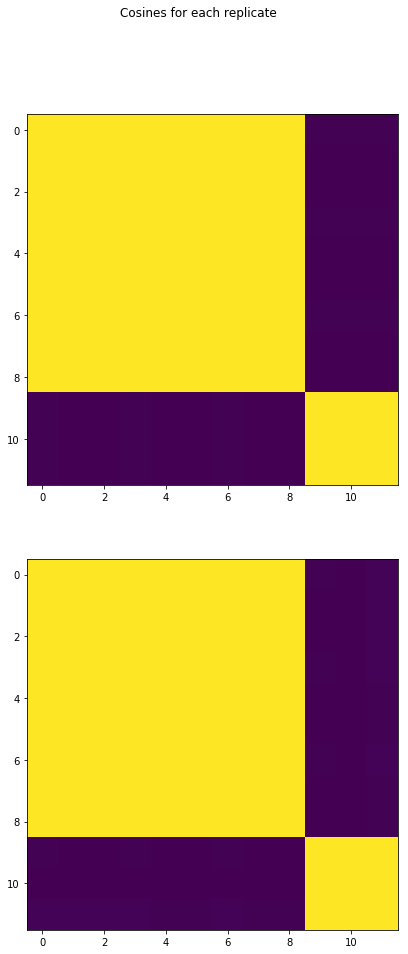

In [54]:
%matplotlib inline
from codes.otherfunctions.multirun import get_cosines
fig, axes_all = plt.subplots(2,figsize=(15,15))
fig.suptitle('Cosines for each replicate')
for i in range(2):
    #full = np.concatenate([replicates[i].dg_M, np.swapaxes(replicates[i].df_M,1,2)],1)
    asdf = get_cosines(replicates[i].dg_M)
    axes_all[i].imshow(asdf)
#fig.savefig(folder + '/cosines')

In [79]:
def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

In [80]:
    dg = replicates[0].dg_M
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,
                                                                :])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    cos_summary = np.sum(coses ** 2, axis=0) / n
    #return (cos_summary)


In [84]:
coses[:,0,9]

array([-0.16050133,  0.08340455, -0.00384155,  0.02507418, -0.06804237,
       -0.02218222,  0.10535787, -0.00422018,  0.14696215,  0.00255905,
       -0.03145519,  0.05181962,  0.15713145, -0.12956094, -0.02138226,
       -0.03951252,  0.05260132, -0.09126729,  0.03668117, -0.08040316,
        0.11031779, -0.10663713,  0.09605069, -0.09458794, -0.00073424,
       -0.03642544, -0.12020165, -0.05316855, -0.02222705, -0.03376008,
        0.10149517, -0.04195251, -0.06490992, -0.08428714, -0.05728615,
       -0.05193801,  0.01941895, -0.04097264,  0.09653019, -0.07500382,
       -0.04432987, -0.01024113, -0.16519721, -0.02623311, -0.11990064,
        0.13634061,  0.01883037, -0.08594354, -0.08441232, -0.0477385 ])

In [85]:
coses[:,0,9]

array([-0.16050133,  0.08340455, -0.00384155,  0.02507418, -0.06804237,
       -0.02218222,  0.10535787, -0.00422018,  0.14696215,  0.00255905,
       -0.03145519,  0.05181962,  0.15713145, -0.12956094, -0.02138226,
       -0.03951252,  0.05260132, -0.09126729,  0.03668117, -0.08040316,
        0.11031779, -0.10663713,  0.09605069, -0.09458794, -0.00073424,
       -0.03642544, -0.12020165, -0.05316855, -0.02222705, -0.03376008,
        0.10149517, -0.04195251, -0.06490992, -0.08428714, -0.05728615,
       -0.05193801,  0.01941895, -0.04097264,  0.09653019, -0.07500382,
       -0.04432987, -0.01024113, -0.16519721, -0.02623311, -0.11990064,
        0.13634061,  0.01883037, -0.08594354, -0.08441232, -0.0477385 ])

In [55]:
    coeffs = replicates[0].coeffs
    selected_functions = np.asarray(np.where(np.sum(np.sum(coeffs ** 2, axis=1), axis=1) > 0))

    sls = np.where(np.asarray(list(Counter(selected_functions[0]).values())) == dim)[0]
    if len(sls) > 0:
        selection_lambda = np.min(sls)
        selected_functions_at_selection_lambda = selected_functions[1][
            np.where(selected_functions[0] == selection_lambda)[0]]


In [56]:
sls

array([17])

In [86]:
r = replicates[0]
cs = experiment.get_betas_spam2(r.xtrain, r.ytrain, r.groups, np.asarray([r.lambdas_plot[17]]), 50, 2, itermax, tol)

In [59]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([5229.54935117,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  430.69493978,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ])

In [ ]:
r = replicates[0]
cs = experiment.get_betas_spam2(r.xtrain, r.ytrain, r.groups, np.asarray([r.lambdas_plot[17]]), 50, 2, itermax, tol)

In [ ]:

    def get_betas_spam2(self, xs, ys, groups, lambdas, n, q, itermax, tol):

        # n = xs.shape[0]
        p = len(np.unique(groups))
        lambdas = np.asarray(lambdas, dtype=np.float64)
        yadd = np.expand_dims(ys, 1)
        groups = np.asarray(groups, dtype=np.int32) + 1
        W0 = np.zeros((xs.shape[1], yadd.shape[1]), dtype=np.float32)
        Xsam = np.asfortranarray(xs, dtype=np.float32)
        Ysam = np.asfortranarray(yadd, dtype=np.float32)
        coeffs = np.zeros((len(lambdas), q, n, p))
        for i in range(len(lambdas)):
            # alpha = spams.fistaFlat(Xsam,Dsam2,alpha0sam,ind_groupsam,lambda1 = lambdas[i],mode = mode,itermax = itermax,tol = tol,numThreads = numThreads, regul = "group-lasso-l2")
            # spams.fistaFlat(Y,X,W0,TRUE,numThreads = 1,verbose = TRUE,lambda1 = 0.05, it0 = 10, max_it = 200,L0 = 0.1, tol = 1e-3, intercept = FALSE,pos = FALSE,compute_gram = TRUE, loss = 'square',regul = 'l1')
            output = spams.fistaFlat(Ysam, Xsam, W0, True, groups=groups, numThreads=-1, verbose=True,
                                     lambda1=lambdas[i], it0=100, max_it=itermax, L0=0.5, tol=tol, intercept=False,
                                     pos=False, compute_gram=True, loss='square', regul='group-lasso-l2', ista=False,
                                     subgrad=False, a=0.1, b=1000)
            coeffs[i, :, :, :] = np.reshape(output[0], (q, n, p))
            # print(output[1])
        return (coeffs)


In [205]:
    def construct_Y(self, df_M):
        """ df_M should have shape n x dim x dim
        """
        n = df_M.shape[0]
        dim = df_M.shape[1]

        #reorg1 = np.swapaxes(df_M, 0, 1)
        yvec = np.reshape(df_M, (n * dim * dim))
        return (yvec)

In [206]:
self=experiment

In [528]:
xtrain,groups = experiment.construct_X(replicates[0].dg_M[:36])
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = 36))
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.23*r.lambdas_plot[17]]), 36, 2, itermax, tol)

In [529]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([  13321.46748733,       0.        ,       0.        ,
             0.        ,       0.        ,       0.        ,
        818168.34223748,       0.        ,       0.        ,
       1354159.68289467,   24323.56221832,       0.        ])

In [233]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([1.45200400e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.93348079e+04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [188]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        , 54367.18892683,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [225]:
replicates[0].dg_M[35]

array([[-0.09560884, -0.04127323],
       [ 0.08677207,  0.03813768],
       [-0.08673297, -0.03815059],
       [-0.09410235, -0.04116909],
       [-0.08561366, -0.03813062],
       [ 0.08554555,  0.03813024],
       [ 0.09456983,  0.04098306],
       [-0.08600274, -0.0379455 ],
       [-0.08603986, -0.03799182],
       [-0.02317432,  0.06240675],
       [ 0.02319112, -0.06225574],
       [-0.02313327,  0.06230341]])

In [226]:
replicates[0].dg_M[36]

array([[ 0.00567825,  0.11278897],
       [-0.00500645, -0.10389345],
       [-0.00496574, -0.10398719],
       [-0.00592985, -0.11243577],
       [ 0.00525256,  0.1038152 ],
       [-0.00521057, -0.10387203],
       [-0.00199892, -0.0593743 ],
       [-0.00164248, -0.0550863 ],
       [ 0.00160336,  0.05522602],
       [-0.0505801 ,  0.00353226],
       [ 0.05053038, -0.00286617],
       [-0.05052673,  0.00292853]])

In [ ]:
replicates[0].dg_M[36]

In [115]:
r.lambdas_plot[17]

0.5625

In [230]:

def get_betas_sam(self, xtrain, ytrain, groups, lambdas, n, q, max_iter, tol, learning_rate):

    p = len(np.unique(groups))
    models = GLM(xs=xtrain, ys=ytrain,
                 tol=tol,
                 group=groups,
                 learning_rate=learning_rate,
                 max_iter=max_iter,
                 # reg_lambda=np.logspace(np.log(100), np.log(0.01), 5, base=np.exp(1)))
                 reg_lambda=lambdas,
                 parameter=.5)
    models.fit()
    nlam = len(lambdas)
    organizedbetas = np.zeros((nlam, q, n, p))
    for l in range(nlam):
        organizedbetas[l, :, :, :] = np.reshape(models.fit_[l]['beta'], (q, n, p))
    # return(models, organizedbetas)
    return (organizedbetas)


In [521]:

cs = experiment.get_betas_sam(xtrain, ytrain, groups, np.asarray([.73*r.lambdas_plot[17]]), 36, 2, 10*itermax, .01*tol, 1)

(144,)
converged 0.410625


ValueError: cannot reshape array of size 144 into shape (2,36,12)

In [538]:
np.var(2*np.reshape(replicates[0].df_M[:,0], (100,1))[:,0])

1.0

In [239]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([2.69287873e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.73108829e+04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [166]:
selpt = [0,1,4,5,6,36]
xtrain,groups = experiment.construct_X(replicates[0].dg_M[selpt])
ytrain = construct_Y(experiment,np.repeat([np.identity(2)], axis = 0, repeats = len(selpt)))
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([.325*r.lambdas_plot[17]]), len(selpt), 2, itermax, tol)

In [167]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([  0.        ,   0.        ,   0.        , 944.6732851 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  20.97637349,   0.        ])

In [573]:
cs = experiment.get_betas_spam2(xtrain, ytrain, groups, np.asarray([5*r.lambdas_plot[17]]), len(selpt), 2, 10*itermax, .01*tol)

In [574]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([6.07725056e+09, 0.00000000e+00, 0.00000000e+00, 1.00419037e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [493]:
np.reshape(cs[0], 2* 6* 12)

array([-5.39502003,  0.        ,  0.        , -0.44825945,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.47909993,  0.        ,  0.        ,
        0.13175256,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -5.4081252 ,
        0.        ,  0.        ,  0.5810263 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  5.44247813,  0.        ,  0.        ,  0.37022509,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -5.35837659,  0.        ,
        0.        ,  0.46282459,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        5.2945989 ,  0.        ,  0.        , -0.46448133,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [598]:
np.linalg.norm(np.linalg.norm(cs[0], axis = 1)**2, axis = 0)**2

array([6.07725056e+09, 0.00000000e+00, 0.00000000e+00, 1.00419037e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [552]:
6.72 / 4.22

4.034 / 2.4

1.6808333333333334

In [491]:
    def _grad_L2loss(beta, X, y):
        #print(beta.shape,X.shape,y.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        n_samples = np.float(X.shape[0])
        z = np.dot(X, beta)
        #grad_beta = 1. / n_samples * np.transpose(np.dot(np.transpose(z - y), X))
        grad_beta = np.transpose(np.dot(np.transpose(z - y), X))
        #print('gb',grad_beta.shape)
        return grad_beta

In [495]:

_grad_L2loss(beta = np.reshape(cs[0], 2* 6* 12), X =xtrain, y= ytrain).shape

(144, 24)

In [585]:
X =xtrain 
y= ytrain
beta = np.reshape(cs[0], 2* 6* 12)

In [586]:
        if y.ndim == 1:
            y = y[:, np.newaxis]
        if beta.ndim == 1:
            beta = beta[:, np.newaxis]
        n_samples = np.float(X.shape[0])
        z = np.dot(X, beta)

        #grad_beta = 1. / n_samples * np.transpose(np.dot(np.transpose(z - y), X))
        grad_beta = np.transpose(np.dot(np.transpose(z - y), X))
        #print('gb',grad_beta.shape)

In [592]:
np.asarray(groups)[np.argsort(np.abs(grad_beta[:,0]))]

array([11, 11, 10, 10,  9,  9,  7,  7,  8,  8, 10, 10, 11, 11,  9,  9,  5,
        5,  4,  4,  1,  1,  2,  2,  0,  0, 10, 10, 11, 11,  9,  9,  6,  6,
        9,  9, 11, 11, 10, 10, 11, 11,  9,  9, 10, 10,  3,  3,  7,  7,  8,
        8,  6,  6,  4,  4,  5,  5,  3,  3,  5,  5,  4,  4,  4,  4,  5,  5,
        1,  1,  5,  5,  2,  2,  4,  4,  7,  7,  7,  7,  1,  1,  8,  8,  2,
        2,  8,  8,  7,  7,  8,  8,  1,  1,  2,  2,  1,  1,  2,  2,  2,  2,
        1,  1,  3,  3,  3,  3,  6,  6,  3,  3,  0,  0,  6,  6,  0,  0,  6,
        6,  0,  0,  0,  0,  0,  0,  4,  4,  5,  5,  7,  7,  8,  8,  3,  3,
        6,  6, 11, 11,  9,  9, 10, 10])

In [597]:
np.abs(grad_beta[:,0])[np.argsort(np.abs(grad_beta[:,0]))]

array([0.01845065, 0.01845065, 0.01892355, 0.01892355, 0.01959235,
       0.01959235, 0.04148805, 0.04148805, 0.04492756, 0.04492756,
       0.05345704, 0.05345704, 0.05394403, 0.05394403, 0.0587133 ,
       0.0587133 , 0.06396295, 0.06396295, 0.06736519, 0.06736519,
       0.07704906, 0.07704906, 0.08047753, 0.08047753, 0.08353886,
       0.08353886, 0.09483158, 0.09483158, 0.09543906, 0.09543906,
       0.09817889, 0.09817889, 0.1208004 , 0.1208004 , 0.15261671,
       0.15261671, 0.15473821, 0.15473821, 0.15562661, 0.15562661,
       0.18548191, 0.18548191, 0.18664576, 0.18664576, 0.18711935,
       0.18711935, 0.23859117, 0.23859117, 0.43117366, 0.43117375,
       0.4322938 , 0.4322939 , 0.46459675, 0.46459685, 0.63217632,
       0.63217632, 0.6323596 , 0.6323596 , 0.68790587, 0.68790587,
       0.77788072, 0.77788072, 0.77814644, 0.77814644, 0.81126425,
       0.81126442, 0.81173586, 0.81173604, 0.81202897, 0.81202915,
       0.81215798, 0.81215798, 0.81278935, 0.81278953, 0.81282

In [593]:
np.argsort(np.abs(grad_beta[:,0]))

array([ 83,  11,  82,  10,  81,   9,  91,  19,  92,  20,  70, 142,  71,
       143,  69, 141,  17,  89,  16,  88,  13,  85,  14,  86,  12,  84,
        34, 106, 107,  35, 105,  33,  18,  90,  45, 117,  47, 119, 118,
        46,  59, 131, 129,  57, 130,  58,  15,  87,  67, 139,  68, 140,
        66, 138,  40, 112, 113,  41,  39, 111,   5,  77,  76,   4,  64,
       136,  65, 137,  61, 133, 125,  53,  62, 134,  52, 124,   7,  79,
        55, 127,  37, 109, 128,  56,  38, 110,  80,   8,  43, 115,  44,
       116,  25,  97,  98,  26,   1,  73,   2,  74, 122,  50,  49, 121,
         3,  75, 123,  51, 126,  54,  63, 135,  60, 132,  78,   6,  48,
       120,  42, 114,  36, 108,   0,  72,  96,  24,  28, 100,  29, 101,
        31, 103,  32, 104,  27,  99, 102,  30,  95,  23,  93,  21,  94,
        22])

In [595]:
83 / 12

6.916666666666667

In [ ]:
#consider the 11s
#0,6 low grad.... 
#1, 7 big grad
#

In [601]:
import spams

In [ ]:
        #def get_betas_spam2(self, xs, ys, groups, lambdas, n, q, itermax, tol):
        xs =xtrain 
        ys= ytrain
        #beta = np.reshape(cs[0], 2* 6* 12)
        np.asarray([5*r.lambdas_plot[17]])
        
        n = len(selpt)
        q = 2
        # n = xs.shape[0]
        p = len(np.unique(groups))
        lambdas = np.asarray(lambdas, dtype=np.float64)
        yadd = np.expand_dims(ys, 1)
        groups = np.asarray(groups, dtype=np.int32) + 1
        W0 = np.zeros((xs.shape[1], yadd.shape[1]), dtype=np.float32)
        Xsam = np.asfortranarray(xs, dtype=np.float32)
        Ysam = np.asfortranarray(yadd, dtype=np.float32)
        coeffs = np.zeros((len(lambdas), q, n, p))
        for i in range(len(lambdas)):
            # alpha = spams.fistaFlat(Xsam,Dsam2,alpha0sam,ind_groupsam,lambda1 = lambdas[i],mode = mode,itermax = itermax,tol = tol,numThreads = numThreads, regul = "group-lasso-l2")
            # spams.fistaFlat(Y,X,W0,TRUE,numThreads = 1,verbose = TRUE,lambda1 = 0.05, it0 = 10, max_it = 200,L0 = 0.1, tol = 1e-3, intercept = FALSE,pos = FALSE,compute_gram = TRUE, loss = 'square',regul = 'l1')
            output = spams.fistaFlat(Ysam, Xsam, W0, True, groups=groups, numThreads=-1, verbose=True,
                                     lambda1=lambdas[i], it0=100, max_it=itermax, L0=0.5, tol=tol, intercept=False,
                                     pos=False, compute_gram=True, loss='square', regul='group-lasso-l2', ista=False,
                                     subgrad=False, a=0.1, b=1000)
            #coeffs[i, :, :, :] = np.reshape(output[0], (q, n, p))
